# mxnet on MNIST
In this notebook, we showcase the effectiveness of Rational Activations on the MNIST image recognition task. After the neccessary imports, the dataset is transformed and created. The model will be a slightly modified VGG11 architecture to fit the input and output dimensions of the MNIST images.

In [1]:
from rational.utils.convert_network import convert_mxnet_model_to_rational
from rational.utils.examples.mxnet import prepare_data_mxnet, train_model_mxnet
from rational.utils.examples.plots import plot_grid

import mxnet
import torch
from mxnet import gpu
from mxnet.gluon.nn import Flatten, Dense
from mxnet.gluon.model_zoo import vision

import matplotlib.pyplot as plt
import numpy as np
plt.style.use('bmh')

### Set random seeds to keep results as deterministic as possible:

In [2]:
seed = 4242
mxnet.random.seed(seed)
np.random.seed(seed)

### Prepare the data generators and training hyperparameters
We apply featurewise normalization, a random rotation range of up to 30 degree and rescaling between 0 and 1 on the inputs. The inputs are reshaped to (32, 32). The outputs are converted into one-hot vectors.

In [3]:
device = gpu(1)
epochs = 100

train_data, test_data = prepare_data_mxnet(batch_size=256)

### Prepare the model for MNIST
Here we cut off the classification layers used for the ImageNet dataset and add a linear layer predicting the ten output classes needed.

In [4]:
vgg = vision.vgg11(pretrained=False)

# modify for mnist
vgg.features = vgg.features[:21]
vgg = vgg.features
vgg.add(Flatten())
vgg.add(Dense(10))

### We can now convert the model
We make use of the Rational Activations by scanning the model and replacing the ReLU layers appropriately. After that, both models are initialized.

In [5]:
rational_model = convert_mxnet_model_to_rational(vgg, rational_device=device)
rational_model.initialize(ctx=device)
vgg.initialize(ctx=device)

### Train the model using the ReLU activation function:

In [6]:
relu_history = train_model_mxnet(vgg, train_data, test_data, device=device, epochs=epochs)

# save model and history
vgg.save_parameters('models/relu_model.mx')
torch.save(relu_history, 'models/relu_model_history.mx')

[Epoch  10] train_acc: 98.24% - train_loss:  0.056
[Epoch  10] val_acc: 98.39% - val_loss:  0.049
Model runtime: 264.637s
[Epoch  20] train_acc: 99.03% - train_loss:  0.030
[Epoch  20] val_acc: 98.70% - val_loss:  0.041
Model runtime: 526.150s
[Epoch  30] train_acc: 99.38% - train_loss:  0.020
[Epoch  30] val_acc: 99.03% - val_loss:  0.032
Model runtime: 787.580s
[Epoch  40] train_acc: 99.59% - train_loss:  0.013
[Epoch  40] val_acc: 99.16% - val_loss:  0.028
Model runtime: 1046.064s
[Epoch  50] train_acc: 99.69% - train_loss:  0.010
[Epoch  50] val_acc: 99.22% - val_loss:  0.027
Model runtime: 1303.304s
[Epoch  60] train_acc: 99.77% - train_loss:  0.007
[Epoch  60] val_acc: 99.13% - val_loss:  0.030
Model runtime: 1558.541s
[Epoch  70] train_acc: 99.84% - train_loss:  0.006
[Epoch  70] val_acc: 99.25% - val_loss:  0.029
Model runtime: 1813.851s
[Epoch  80] train_acc: 99.87% - train_loss:  0.004
[Epoch  80] val_acc: 99.03% - val_loss:  0.036
Model runtime: 2064.486s
[Epoch  90] train_a

In [6]:
# load to save training time
vgg.load_parameters('models/relu_model.mx', ctx=device)
relu_history = torch.load('models/relu_model_history.mx')

### Train the model using the Rational Activations:

In [ ]:
rational_history = train_model_mxnet(rational_model, train_data, test_data, device=device, epochs=epochs)

# save model and history
rational_model.save_parameters('models/rational_model.mx')
torch.save(rational_history, 'models/rational_model_history.mx')

[Epoch  10] train_acc: 98.98% - train_loss:  0.031
[Epoch  10] val_acc: 97.33% - val_loss:  0.081
Model runtime: 379.376s


In [7]:
# load to save training time
rational_model.load_parameters('models/rational_model.mx', ctx=device)
rational_history = torch.load('models/rational_model_history.mx')

### Plot the training and validation metrics:

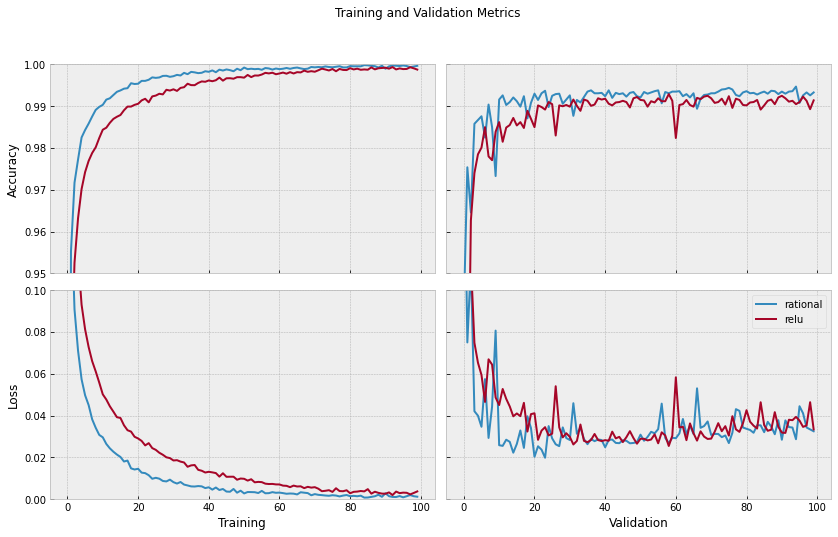

In [8]:
plot_grid({'rational': rational_history, 'relu': relu_history})